#### LoRA 的核心思想

> 在微调阶段，不直接更新原始权重矩阵，而是对权重矩阵的增量更新进行低秩分解，只学习一个低秩的调整矩阵。

用公式描述：

假设原始模型有一个权重矩阵 ($ W_0 \in \mathbb{R}^{d \times k} $)，LoRA 将微调目标表示为：

$$
W = W_0 + \Delta W
$$

其中 ($\Delta W$) 不直接学习完整的 ($d \times k$) 矩阵，而是通过低秩分解表示：

$$
\Delta W = A B
$$

* ($A \in \mathbb{R}^{d \times r}$)
* ($B \in \mathbb{R}^{r \times k}$)
* ($r \ll \min(d, k)$) 是低秩维度

这样，原本需要学习的 ($d \times k$) 参数量，现在只需学习 ($r(d + k)$) 个参数，大大减少了微调开销。

---

#### 低秩矩阵分解原理

LoRA 的理论基础就是 **矩阵低秩分解**：

* 对于一个矩阵 ($X \in \mathbb{R}^{d \times k}$)，如果它是高维但信息冗余较多（典型大模型情况），它可以被近似为一个 **低秩矩阵**：

$$
X \approx A B
$$

* 这里 ($A \in \mathbb{R}^{d \times r}, B \in \mathbb{R}^{r \times k}$)，秩 ($r$) 很小
* 可以通过奇异值分解（SVD）理论说明：

$$
X = U \Sigma V^\top \approx U_r \Sigma_r V_r^\top
$$

* 其中 ($U_r \Sigma_r$) 可以对应 LoRA 的 ($A$)，($V_r^\top$) 对应 ($B$)
* 保留前 ($r$) 个奇异值可以近似原矩阵的主要信息

直观理解：

* 微调时权重更新的变化通常在一个 **低维子空间** 内（很多权重变化高度相关）
* 因此只学习低秩矩阵 ($A$) 和 ($B$) 就足够捕捉主要的任务相关调整

---

#### LoRA 在注意力层中的应用

在 Transformer 的自注意力中，权重矩阵 ($W_q, W_k, W_v$) 都可以通过 LoRA 进行低秩微调：

$$
W_q^\text{tuned} = W_q + A_q B_q
$$

* ($W_q$) 冻结（不更新）
* 只训练 ($A_q$) 和 ($B_q$)
* 前向计算：

$$
\text{output} = (W_q + \alpha A_q B_q)x = W_q x + \alpha (A_q (B_q x))
$$

* ($\alpha$) 是缩放因子，通常用来控制低秩更新对输出的影响

好处：

* 微调参数显著减少
* 原始权重不被破坏（可共享、可回退）
* 训练更快，显存占用更小

---

#### 参数量分析

假设原始矩阵 ($W \in \mathbb{R}^{d \times k}$)，LoRA 选择秩 ($r$)：

* 原始更新参数量：($d \cdot k$)
* LoRA 参数量：($r \cdot (d + k)$)

举例：

* ($d = 4096, k = 4096$)，直接微调需要 ($16\text{M}$) 参数
* 选 ($r = 16$)，LoRA 只需 ($16 \cdot (4096 + 4096) = 131072$) 参数（约 0.8%）

显著降低存储和练成本。

---

#### 总结

* LoRA 利用 **低秩矩阵分解** 的原理，将微调权重更新限制在低秩子空间。
* 通过学习两个小矩阵 (A) 和 (B)，近似表示完整权重的变化。
* 优势：高效、低成本、可迁移性强。
* 核心公式：

$$
W = W_0 + \Delta W, \quad \Delta W = A B, \quad r \ll \min(d, k)
$$

---


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel, BertTokenizer
from torch.utils.data import DataLoader, TensorDataset

In [43]:
# LoRA模块定义
class LoRA(nn.Module):
    def __init__(self, input_dim: int, rank: int=4) -> None:
        super(LoRA, self).__init__()
        self.rank = rank
        self.down_projection = nn.Linear(in_features=input_dim, out_features=rank, bias=False)
        self.up_projection = nn.Linear(in_features=rank, out_features=input_dim, bias=False)
    
    def forward(self, x):
        down_output = self.down_projection(x)
        up_projection = self.up_projection(down_output)
        return up_projection

In [44]:
# 将LoRA集成到BERT的自注意力模块中
class BertWithLoRA(nn.Module):
    def __init__(self, lora_rank: int=4):
        super(BertWithLoRA, self).__init__()

        self.bert = BertModel.from_pretrained('../bert-base-uncased')
        # 为每层自注意力模块添加LoRA
        self.lora_modules = nn.ModuleList([
            LoRA(self.bert.config.hidden_size, lora_rank) for _ in range(self.bert.config.num_hidden_layers)
        ])

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = list(outputs.hidden_states)
        # 每层应用LoRA模块进行微调
        for i, lora in enumerate(self.lora_modules):
            hidden_states[i + 1] = hidden_states[i + 1] + lora(hidden_states[i + 1])
        return hidden_states[-1]

In [45]:
# 加载BERT分词器
tokenizer = BertTokenizer.from_pretrained('../bert-base-uncased')

# 模拟数据加载
def prepare_data(texts, labels, tokenizer, max_length=128):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    input_ids, attention_mask = encodings['input_ids'], encodings['attention_mask']
    labels = torch.tensor(labels)
    return TensorDataset(input_ids, attention_mask, labels)

# 示例数据
texts = [
    'LoRA efficiently adapts large models.',
    'This technique uses low-rank updates.'
]
labels = [1, 0]

dataset = prepare_data(texts, labels, tokenizer)
dataloader = DataLoader(dataset=dataset, batch_size=2)

In [46]:
# 实例化模型与训练组件
model = BertWithLoRA(lora_rank=4)
optimizer = optim.Adam(model.lora_modules.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 601.55it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: ../bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def train_one_epoch(dataloader, model, criterion, optimizer):
    model.train()
    total_loss, correct_predictions = 0, 0
    for batch in dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        # 前向传播
        outputs = model(input_ids, attention_mask)
        logits = outputs[:, 0, :]
        loss = criterion(logits, labels)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录损失
        total_loss += loss.detach().cpu().numpy()
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions * 1.0 / len(dataloader.dataset)
    return avg_loss, accuracy

In [48]:
loss_history = []
for epoch in range(300):
    avg_loss, accuracy = train_one_epoch(dataloader, model, criterion, optimizer)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1, Loss: 7.1780, Accuracy: 0.0000
Epoch 2, Loss: 7.0883, Accuracy: 0.0000
Epoch 3, Loss: 6.9366, Accuracy: 0.0000
Epoch 4, Loss: 7.1250, Accuracy: 0.0000
Epoch 5, Loss: 7.0060, Accuracy: 0.0000
Epoch 6, Loss: 6.8289, Accuracy: 0.0000
Epoch 7, Loss: 6.7758, Accuracy: 0.0000
Epoch 8, Loss: 7.0193, Accuracy: 0.0000
Epoch 9, Loss: 6.9988, Accuracy: 0.0000
Epoch 10, Loss: 6.7632, Accuracy: 0.0000
Epoch 11, Loss: 6.9143, Accuracy: 0.0000
Epoch 12, Loss: 6.9292, Accuracy: 0.0000
Epoch 13, Loss: 6.8761, Accuracy: 0.0000
Epoch 14, Loss: 6.8665, Accuracy: 0.0000
Epoch 15, Loss: 6.7758, Accuracy: 0.0000
Epoch 16, Loss: 6.8596, Accuracy: 0.0000
Epoch 17, Loss: 7.0200, Accuracy: 0.0000
Epoch 18, Loss: 6.8484, Accuracy: 0.0000
Epoch 19, Loss: 6.6816, Accuracy: 0.0000
Epoch 20, Loss: 6.7955, Accuracy: 0.0000
Epoch 21, Loss: 6.7685, Accuracy: 0.0000
Epoch 22, Loss: 6.8118, Accuracy: 0.0000
Epoch 23, Loss: 6.7610, Accuracy: 0.0000
Epoch 24, Loss: 6.6524, Accuracy: 0.0000
Epoch 25, Loss: 6.7021, A

绘制训练损失曲线... [np.float32(7.178032), np.float32(7.0883036), np.float32(6.9366107), np.float32(7.124983), np.float32(7.0060453), np.float32(6.828866), np.float32(6.775813), np.float32(7.0192857), np.float32(6.9988365), np.float32(6.7631607), np.float32(6.9143295), np.float32(6.929213), np.float32(6.876083), np.float32(6.8664894), np.float32(6.775818), np.float32(6.8595552), np.float32(7.019965), np.float32(6.848407), np.float32(6.68161), np.float32(6.795491), np.float32(6.7684927), np.float32(6.8117704), np.float32(6.760961), np.float32(6.6524), np.float32(6.7021), np.float32(6.4956036), np.float32(6.620061), np.float32(6.835829), np.float32(6.5406446), np.float32(6.5643377), np.float32(6.888118), np.float32(6.528247), np.float32(6.7296777), np.float32(6.595373), np.float32(6.522292), np.float32(6.575354), np.float32(6.458154), np.float32(6.570686), np.float32(6.7943497), np.float32(6.550362), np.float32(6.549902), np.float32(6.6697464), np.float32(6.57086), np.float32(6.6301827), np.floa

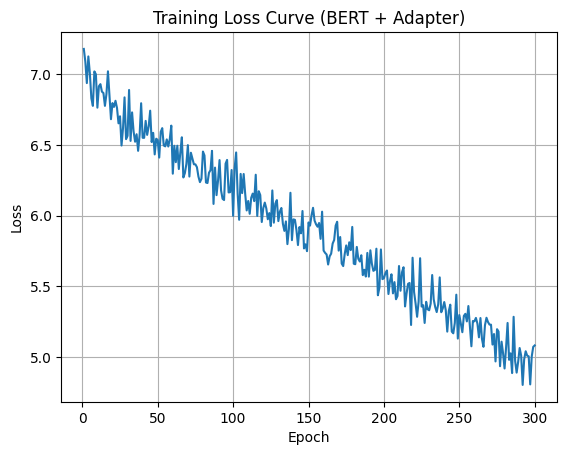

In [49]:
def plot_loss_curve(loss_history):
    import matplotlib.pyplot as plt

    print("绘制训练损失曲线...", loss_history)
    plt.figure()
    plt.plot(range(1, len(loss_history) + 1), loss_history)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve (BERT + Adapter)")
    plt.grid(True)
    plt.show()


plot_loss_curve(loss_history)